In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Compare NIBIO background coefficients to TEOTIL3

Marianne has sent a presentation containing background coefficients used by the agricultural models (see e-mail received 21.08.2023 at 16.16). I think these coefficients represent expected background fluxes from agricultural areas *if they were natural* (i.e. no agriculture). Since these coefficients have been estimated independently, it is interesting to compare them with the new values from TEOTIL3.

## 1. Convert TEOTIL coefficients

From concentrations to kg/da/yr, assuming long-term average runoff (1990 - 2021).

In [4]:
coeff_csv = r"../../../data/spatially_variable_background_coefficients.csv"

In [5]:
# Read regines
data_fold = "/home/jovyan/shared/common/teotil3/core_data"
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
reg_csv = os.path.join(data_fold, "tidied", "regines.csv")
reg_gdf = gpd.read_file(teo_gpkg, layer="regines", driver="GPKG")
reg_gdf = reg_gdf[["regine", "runoff_mm/yr", "geometry"]]

# Background coeffs
coef_df = pd.read_csv(coeff_csv)
coef_df = coef_df[["regine", "wood_totn_µg/l", "wood_totp_µg/l"]]

# Join
gdf = reg_gdf.merge(coef_df, how="left", on="regine")
gdf.head()

,regine,runoff_mm/yr,geometry,wood_totn_µg/l,wood_totp_µg/l
0,001.10,592,"POLYGON ((297006.830 6543966.950, 297169.290 6...",491.9,12.1
1,001.1A1,620,"POLYGON ((297505.440 6543157.790, 297543.100 6...",492.3,12.1
2,001.1A20,594,"POLYGON ((297770.368 6543429.036, 297787.114 6...",492.8,12.1
3,001.1A2A,637,"POLYGON ((299678.370 6544460.320, 299667.220 6...",494.5,12.2
4,001.1A2B,637,"POLYGON ((303353.460 6552989.330, 303341.620 6...",495.3,12.3


In [6]:
# Check for NaN
pd.isna(gdf).sum(axis="rows")

regine            0
runoff_mm/yr      0
geometry          0
wood_totn_µg/l    0
wood_totp_µg/l    0
dtype: int64

In [7]:
# Convert units
gdf["wood_totn_kg/da/yr"] = 1000 * gdf["runoff_mm/yr"] * gdf["wood_totn_µg/l"] / 1e9
gdf["wood_totp_g/da/yr"] = 1000 * gdf["runoff_mm/yr"] * gdf["wood_totp_µg/l"] / 1e6
gdf = gdf.query("`runoff_mm/yr` > 0")
gdf.describe(percentiles=[.01, .25, .5, .75, .99])

,runoff_mm/yr,wood_totn_µg/l,wood_totp_µg/l,wood_totn_kg/da/yr,wood_totp_g/da/yr
count,23930.000000,23930.000000,23930.000000,23930.000000,23930.000000
mean,1557.813623,239.581425,6.452913,0.342935,8.649486
std,944.617322,67.687053,2.148068,0.188552,3.765310
min,158.000000,96.800000,3.200000,0.041175,1.358800
1%,327.000000,114.458000,3.900000,0.089377,2.832812
25%,762.000000,201.700000,4.900000,0.192325,5.719150
50%,1380.000000,220.500000,5.900000,0.293623,8.038800
75%,2139.000000,264.700000,7.200000,0.464134,11.039325
99%,4143.130000,468.071000,14.000000,0.854443,19.312956
max,5650.000000,501.400000,15.100000,1.098720,26.271000


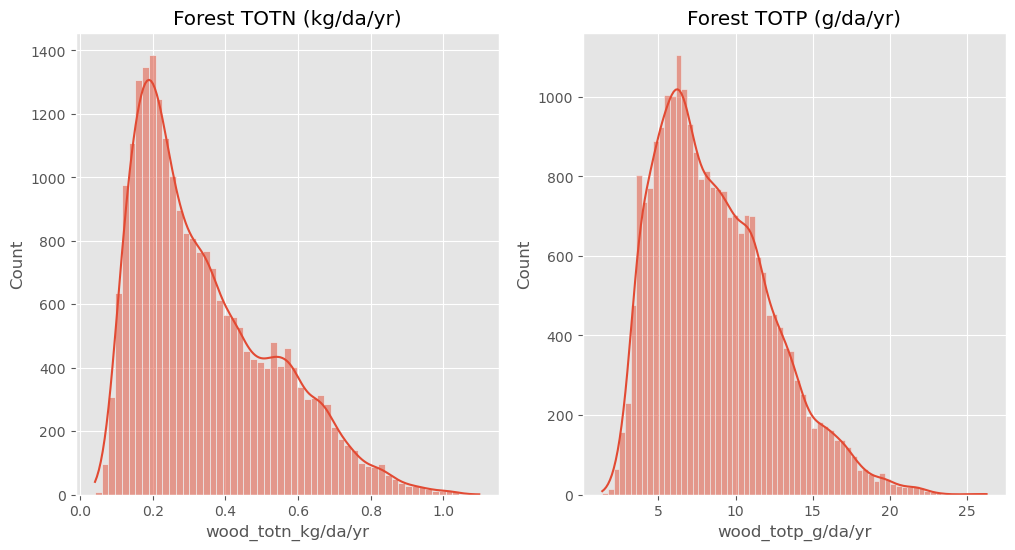

In [8]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sn.histplot(data=gdf["wood_totn_kg/da/yr"], kde=True, ax=axes[0])
sn.histplot(data=gdf["wood_totp_g/da/yr"], kde=True, ax=axes[1])
axes[0].set_title("Forest TOTN (kg/da/yr)")
axes[1].set_title("Forest TOTP (g/da/yr)");